In [20]:
import pandas as pd
from scipy.stats import shapiro, levene, f_oneway
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

         agegroup          time             
            count          mean          std
agegroup                                    
30            657  15935.200913  2091.516558
35            686  15928.749271  2168.780190
40            661  15995.394856  2123.196163
45            458  16105.969432  1972.153908
50            251  16448.968127  2189.249495
55            116  16764.077586  2045.042936


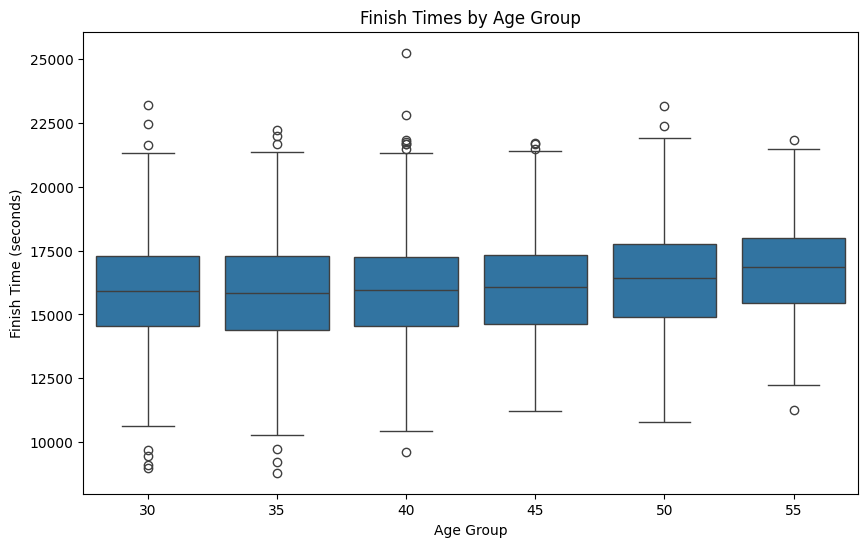

In [ ]:

data = pd.read_csv("marathon_women_berlin.csv", index_col=0, sep=",")


agegroups_stats = data.groupby('agegroup').agg({'agegroup': 'count', 'time': ['mean', 'std']})

print(agegroups_stats)

plt.figure(figsize=(10, 6))
sns.boxplot(x='agegroup', y='time', data=data)
plt.title('Finish Times by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Finish Time (seconds)')
plt.show()


In [16]:
age_groups_dict = {age: data[data['agegroup'] == age]['time'] for age in [30, 35, 40, 45, 50, 55]}
normality_results = {}
for age in age_groups_dict:
    group_time = age_groups_dict[age]
    stat, p_value = shapiro(group_time)  # Perform the Shapiro-Wilk test for normality
    normality_results[age] = p_value
    print(f"Shapiro-Wilk Test for Age Group {age}: p-value = {p_value:.4f}")

Shapiro-Wilk Test for Age Group 30: p-value = 0.6471
Shapiro-Wilk Test for Age Group 35: p-value = 0.0595
Shapiro-Wilk Test for Age Group 40: p-value = 0.0010
Shapiro-Wilk Test for Age Group 45: p-value = 0.0785
Shapiro-Wilk Test for Age Group 50: p-value = 0.3964
Shapiro-Wilk Test for Age Group 55: p-value = 0.9255


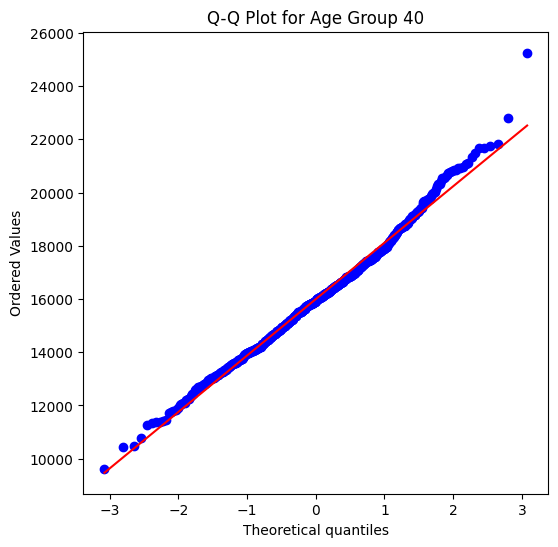

In [17]:
group_time_40 = age_groups_dict[40]
plt.figure(figsize=(6, 6))
stats.probplot(group_time_40, dist="norm", plot=plt)
plt.title('Q-Q Plot for Age Group 40')
plt.show()

In [18]:
age_groups = {
    '30': data[data['agegroup'] == 30]['time'],
    '35': data[data['agegroup'] == 35]['time'],
    '40': data[data['agegroup'] == 40]['time'],
    '45': data[data['agegroup'] == 45]['time'],
    '50': data[data['agegroup'] == 50]['time'],
    '55': data[data['agegroup'] == 55]['time'],
}

stat, p = levene(age_groups['30'], age_groups['35'], age_groups['40'], 
                 age_groups['45'], age_groups['50'], age_groups['55'])
print(f"Levene’s Test for Homogeneity of Variances: Test Statistic = {stat:.4f}, p-value = {p:.4f}")


Levene’s Test for Homogeneity of Variances: Test Statistic = 0.9415, p-value = 0.4528


In [21]:
age_groups = data['agegroup'].unique()

pairwise_results = []
alpha = 0.05 
num_comparisons = len(list(itertools.combinations(age_groups, 2)))

for group1, group2 in itertools.combinations(age_groups, 2):
    group1_times = data[data['agegroup'] == group1]['time']
    group2_times = data[data['agegroup'] == group2]['time']
    
    
    t_stat, p_value = stats.ttest_ind(group1_times, group2_times)
    
    p_value_adj = p_value * num_comparisons
    p_value_adj = min(p_value_adj, 1) 
    
    
    pairwise_results.append({
        'Comparison': f"{group1}-{group2}",
        't-statistic': t_stat,
        'p-value': p_value,
        'Bonferroni-adjusted p-value': p_value_adj
    })

pairwise_df = pd.DataFrame(pairwise_results)
print("Pairwise T-Test Results with Bonferroni Correction:")
print(pairwise_df[['Comparison', 't-statistic', 'p-value', 'Bonferroni-adjusted p-value']])


Pairwise T-Test Results with Bonferroni Correction:
   Comparison  t-statistic   p-value  Bonferroni-adjusted p-value
0       35-30    -0.055453  0.955786                     1.000000
1       35-40    -0.569656  0.569006                     1.000000
2       35-50    -3.243406  0.001223                     0.018344
3       35-45    -1.403680  0.160686                     1.000000
4       35-55    -3.867530  0.000119                     0.001783
5       30-40    -0.518464  0.604222                     1.000000
6       30-50    -3.267573  0.001126                     0.016883
7       30-45    -1.372913  0.170056                     1.000000
8       30-55    -3.948013  0.000086                     0.001290
9       40-50    -2.856671  0.004379                     0.065679
10      40-45    -0.881718  0.378119                     1.000000
11      40-55    -3.615907  0.000319                     0.004780
12      50-45     2.128910  0.033607                     0.504101
13      50-55    -1.3085

In [ ]:
tukey_result = pairwise_tukeyhsd(data['time'], data['agegroup'], alpha=0.05)

tukey_summary = tukey_result.summary()

tukey_df = pd.DataFrame(tukey_summary.data[1:], columns=tukey_summary.data[0])

tukey_df['Comparison'] = tukey_df.apply(lambda row: f"{min(row['group1'], row['group2'])}-{max(row['group1'], row['group2'])}", axis=1)

tukey_df = tukey_df[['Comparison', 'meandiff', 'p-adj', 'lower', 'upper', 'reject']]

print("Tukey HSD Test Results:")
print(tukey_df)


Tukey HSD Test Results:
   Comparison  meandiff   p-adj     lower      upper  reject
0       30-35   -6.4516  1.0000 -334.3197   321.4164   False
1       30-40   60.1939  0.9955 -270.6934   391.0812   False
2       30-45  170.7685  0.7673 -194.8497   536.3867   False
3       30-50  513.7672  0.0131   68.0810   959.4534    True
4       30-55  828.8767  0.0013  223.9763  1433.7771    True
5       35-40   66.6456  0.9923 -260.7153   394.0065   False
6       35-45  177.2202  0.7305 -185.2097   539.6501   False
7       35-50  520.2189  0.0107   77.1444   963.2933    True
8       35-55  835.3283  0.0011  232.3497  1438.3070    True
9       40-45  110.5746  0.9551 -254.5889   475.7381   False
10      40-50  453.5733  0.0430    8.2600   898.8865    True
11      40-55  768.6827  0.0040  164.0571  1373.3084    True
12      45-50  342.9987  0.3014 -128.6942   814.6916   False
13      45-55  658.1082  0.0319   33.7986  1282.4178    True
14      50-55  315.1095  0.7669 -359.2213   989.4402   False


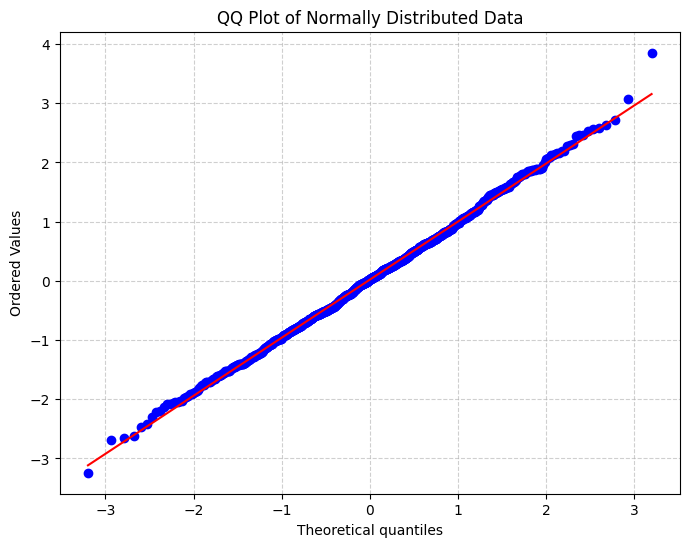

In [ ]:

np.random.seed(42)
data = np.random.normal(loc=0, scale=1, size=1000)
fig, ax = plt.subplots(figsize=(8, 6))
stats.probplot(data, dist="norm", plot=ax)
ax.set_title("QQ Plot of Normally Distributed Data")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

